# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test.values

preprocess.x_train.shape

(125973, 122)

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 18

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=1e-5
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score'])

    predictions = {}

    results = []
    best_acc = 0
    
    def train(epochs, net, h,f):
        batch_iterations = 200
    
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())

            for epoch in range(1, (epochs+1)):
                x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
                batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
                for i in batch_indices:
                    _, train_loss = sess.run([net.train_op, 
                                                           net.regularized_loss, 
                                                           ], #net.summary_op
                                                          feed_dict={net.x: x_train[i,:], 
                                                                     net.y_: y_train[i,:], 
                                                                     net.keep_prob:0.5})
                    
                    #summary_writer_train.add_summary(summary_str, epoch)
                    if(train_loss > 1e9):
                        print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                    

                valid_accuracy = sess.run(net.tf_accuracy, #net.summary_op 
                                                      feed_dict={net.x: x_valid, 
                                                                 net.y_: y_valid, 
                                                                 net.keep_prob:1})
                #summary_writer_valid.add_summary(summary_str, epoch)

                
                accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                               net.pred, 
                                                               net.actual, net.y], 
                                                              feed_dict={net.x: preprocess.x_test, 
                                                                         net.y_: preprocess.y_test, 
                                                                         net.keep_prob:1})

                print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))
                print("Accuracy on Test data: {}".format(accuracy))

                if accuracy > Train.best_acc:
                    Train.best_acc = accuracy
                    Train.pred_value = pred_value
                    Train.actual_value = actual_value
                    Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)
                    net.saver.save(sess, 
                                   "dataset/tf_dense_only_nsl_kdd_hidden layers_{}_features count_{}".format(h,f),
                                    global_step = epochs)
                    curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                    Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

                    Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
            

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 32, 64]
    hidden_layers_arr = [4, 6]

    epochs = [100]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f)
        

Current Layer Attributes - epochs:100 hidden layers:4 features count:4
Step 1 | Training Loss: 0.694541 | Validation Accuracy: 0.736863
Accuracy on Test data: 0.8004347085952759
Step 2 | Training Loss: 0.704481 | Validation Accuracy: 0.774964
Accuracy on Test data: 0.8143630027770996
Step 3 | Training Loss: 0.683983 | Validation Accuracy: 0.802032
Accuracy on Test data: 0.8250975608825684
Step 4 | Training Loss: 0.691342 | Validation Accuracy: 0.850452
Accuracy on Test data: 0.8640879988670349
Step 5 | Training Loss: 0.670866 | Validation Accuracy: 0.872837
Accuracy on Test data: 0.8533090949058533
Step 6 | Training Loss: 0.675836 | Validation Accuracy: 0.897047
Accuracy on Test data: 0.8483853936195374
Step 7 | Training Loss: 0.668828 | Validation Accuracy: 0.909033
Accuracy on Test data: 0.8511798977851868
Step 8 | Training Loss: 0.674895 | Validation Accuracy: 0.918638
Accuracy on Test data: 0.8477200269699097
Step 9 | Training Loss: 0.669289 | Validation Accuracy: 0.921019
Accuracy

Step 77 | Training Loss: 0.596902 | Validation Accuracy: 0.967931
Accuracy on Test data: 0.7585610151290894
Step 78 | Training Loss: 0.599263 | Validation Accuracy: 0.969598
Accuracy on Test data: 0.7582061886787415
Step 79 | Training Loss: 0.592224 | Validation Accuracy: 0.968090
Accuracy on Test data: 0.7582948803901672
Step 80 | Training Loss: 0.588135 | Validation Accuracy: 0.969122
Accuracy on Test data: 0.7581174373626709
Step 81 | Training Loss: 0.606941 | Validation Accuracy: 0.967852
Accuracy on Test data: 0.7578956484794617
Step 82 | Training Loss: 0.588714 | Validation Accuracy: 0.966503
Accuracy on Test data: 0.7578513026237488
Step 83 | Training Loss: 0.594029 | Validation Accuracy: 0.969519
Accuracy on Test data: 0.7576295137405396
Step 84 | Training Loss: 0.596955 | Validation Accuracy: 0.967455
Accuracy on Test data: 0.7576295137405396
Step 85 | Training Loss: 0.585315 | Validation Accuracy: 0.967693
Accuracy on Test data: 0.7576738595962524
Step 86 | Training Loss: 0.6

Step 53 | Training Loss: 0.594796 | Validation Accuracy: 0.959279
Accuracy on Test data: 0.8148953318595886
Step 54 | Training Loss: 0.591440 | Validation Accuracy: 0.957692
Accuracy on Test data: 0.8107256889343262
Step 55 | Training Loss: 0.576363 | Validation Accuracy: 0.958803
Accuracy on Test data: 0.8089957237243652
Step 56 | Training Loss: 0.578451 | Validation Accuracy: 0.960152
Accuracy on Test data: 0.8052253127098083
Step 57 | Training Loss: 0.577767 | Validation Accuracy: 0.964280
Accuracy on Test data: 0.8046486973762512
Step 58 | Training Loss: 0.584076 | Validation Accuracy: 0.961581
Accuracy on Test data: 0.8031848669052124
Step 59 | Training Loss: 0.574500 | Validation Accuracy: 0.961184
Accuracy on Test data: 0.8022977113723755
Step 60 | Training Loss: 0.571596 | Validation Accuracy: 0.960787
Accuracy on Test data: 0.8014105558395386
Step 61 | Training Loss: 0.569724 | Validation Accuracy: 0.959756
Accuracy on Test data: 0.8001242280006409
Step 62 | Training Loss: 0.5

Step 29 | Training Loss: 0.421217 | Validation Accuracy: 0.961264
Accuracy on Test data: 0.7895227074623108
Step 30 | Training Loss: 0.414353 | Validation Accuracy: 0.960867
Accuracy on Test data: 0.7875709533691406
Step 31 | Training Loss: 0.421692 | Validation Accuracy: 0.964598
Accuracy on Test data: 0.7845990061759949
Step 32 | Training Loss: 0.380601 | Validation Accuracy: 0.965629
Accuracy on Test data: 0.7834900617599487
Step 33 | Training Loss: 0.410987 | Validation Accuracy: 0.963407
Accuracy on Test data: 0.781981885433197
Step 34 | Training Loss: 0.402360 | Validation Accuracy: 0.965629
Accuracy on Test data: 0.7810947299003601
Step 35 | Training Loss: 0.402199 | Validation Accuracy: 0.967296
Accuracy on Test data: 0.7806511521339417
Step 36 | Training Loss: 0.385702 | Validation Accuracy: 0.968487
Accuracy on Test data: 0.7804737687110901
Step 37 | Training Loss: 0.379680 | Validation Accuracy: 0.967296
Accuracy on Test data: 0.7804737687110901
Step 38 | Training Loss: 0.38

Step 5 | Training Loss: 0.609877 | Validation Accuracy: 0.908716
Accuracy on Test data: 0.8219925761222839
Step 6 | Training Loss: 0.615432 | Validation Accuracy: 0.916574
Accuracy on Test data: 0.8202182650566101
Step 7 | Training Loss: 0.580660 | Validation Accuracy: 0.922289
Accuracy on Test data: 0.819730281829834
Step 8 | Training Loss: 0.546790 | Validation Accuracy: 0.920781
Accuracy on Test data: 0.8207061886787415
Step 9 | Training Loss: 0.531633 | Validation Accuracy: 0.926734
Accuracy on Test data: 0.8180890679359436
Step 10 | Training Loss: 0.514718 | Validation Accuracy: 0.928560
Accuracy on Test data: 0.8168026804924011
Step 11 | Training Loss: 0.491329 | Validation Accuracy: 0.934275
Accuracy on Test data: 0.8148509860038757
Step 12 | Training Loss: 0.465700 | Validation Accuracy: 0.939911
Accuracy on Test data: 0.813342809677124
Step 13 | Training Loss: 0.472370 | Validation Accuracy: 0.946420
Accuracy on Test data: 0.8122782111167908
Step 14 | Training Loss: 0.446437 |

Step 81 | Training Loss: 0.356386 | Validation Accuracy: 0.973170
Accuracy on Test data: 0.7658800482749939
Step 82 | Training Loss: 0.332795 | Validation Accuracy: 0.975869
Accuracy on Test data: 0.7635291218757629
Step 83 | Training Loss: 0.349752 | Validation Accuracy: 0.976345
Accuracy on Test data: 0.7635291218757629
Step 84 | Training Loss: 0.338087 | Validation Accuracy: 0.976663
Accuracy on Test data: 0.7635291218757629
Step 85 | Training Loss: 0.343595 | Validation Accuracy: 0.972377
Accuracy on Test data: 0.7635291218757629
Step 86 | Training Loss: 0.356380 | Validation Accuracy: 0.974679
Accuracy on Test data: 0.7634403705596924
Step 87 | Training Loss: 0.347918 | Validation Accuracy: 0.975790
Accuracy on Test data: 0.7633960247039795
Step 88 | Training Loss: 0.349770 | Validation Accuracy: 0.973647
Accuracy on Test data: 0.7633073329925537
Step 89 | Training Loss: 0.347009 | Validation Accuracy: 0.976980
Accuracy on Test data: 0.7633516788482666
Step 90 | Training Loss: 0.3

Step 56 | Training Loss: 0.680395 | Validation Accuracy: 0.533339
Accuracy on Test data: 0.43075764179229736
Step 57 | Training Loss: 0.687015 | Validation Accuracy: 0.533497
Accuracy on Test data: 0.43075764179229736
Step 58 | Training Loss: 0.677017 | Validation Accuracy: 0.534847
Accuracy on Test data: 0.43075764179229736
Step 59 | Training Loss: 0.681358 | Validation Accuracy: 0.536355
Accuracy on Test data: 0.43075764179229736
Step 60 | Training Loss: 0.678423 | Validation Accuracy: 0.537228
Accuracy on Test data: 0.43075764179229736
Step 61 | Training Loss: 0.668685 | Validation Accuracy: 0.532148
Accuracy on Test data: 0.43075764179229736
Step 62 | Training Loss: 0.684250 | Validation Accuracy: 0.532227
Accuracy on Test data: 0.43075764179229736
Step 63 | Training Loss: 0.686641 | Validation Accuracy: 0.529449
Accuracy on Test data: 0.43075764179229736
Step 64 | Training Loss: 0.670216 | Validation Accuracy: 0.526036
Accuracy on Test data: 0.43075764179229736
Step 65 | Training 

Step 31 | Training Loss: 0.672543 | Validation Accuracy: 0.526830
Accuracy on Test data: 0.4427785575389862
Step 32 | Training Loss: 0.678040 | Validation Accuracy: 0.536117
Accuracy on Test data: 0.442556768655777
Step 33 | Training Loss: 0.669943 | Validation Accuracy: 0.528655
Accuracy on Test data: 0.44224628806114197
Step 34 | Training Loss: 0.670405 | Validation Accuracy: 0.538895
Accuracy on Test data: 0.4422019124031067
Step 35 | Training Loss: 0.662367 | Validation Accuracy: 0.535720
Accuracy on Test data: 0.44198012351989746
Step 36 | Training Loss: 0.658069 | Validation Accuracy: 0.538657
Accuracy on Test data: 0.44171398878097534
Step 37 | Training Loss: 0.667325 | Validation Accuracy: 0.535402
Accuracy on Test data: 0.43115684390068054
Step 38 | Training Loss: 0.657058 | Validation Accuracy: 0.535323
Accuracy on Test data: 0.43075764179229736
Step 39 | Training Loss: 0.662801 | Validation Accuracy: 0.539530
Accuracy on Test data: 0.43075764179229736
Step 40 | Training Loss

Step 7 | Training Loss: 0.665296 | Validation Accuracy: 0.902842
Accuracy on Test data: 0.826339602470398
Step 8 | Training Loss: 0.654973 | Validation Accuracy: 0.900460
Accuracy on Test data: 0.8461231589317322
Step 9 | Training Loss: 0.651225 | Validation Accuracy: 0.910065
Accuracy on Test data: 0.8540631532669067
Step 10 | Training Loss: 0.628961 | Validation Accuracy: 0.923718
Accuracy on Test data: 0.8558374643325806
Step 11 | Training Loss: 0.635476 | Validation Accuracy: 0.935069
Accuracy on Test data: 0.8574787378311157
Step 12 | Training Loss: 0.652570 | Validation Accuracy: 0.940705
Accuracy on Test data: 0.8586763739585876
Step 13 | Training Loss: 0.625304 | Validation Accuracy: 0.941261
Accuracy on Test data: 0.862358033657074
Step 14 | Training Loss: 0.605809 | Validation Accuracy: 0.943880
Accuracy on Test data: 0.8645315766334534
Step 15 | Training Loss: 0.603223 | Validation Accuracy: 0.942372
Accuracy on Test data: 0.8674591779708862
Step 16 | Training Loss: 0.594360

Step 83 | Training Loss: 0.361596 | Validation Accuracy: 0.969836
Accuracy on Test data: 0.7801188826560974
Step 84 | Training Loss: 0.368858 | Validation Accuracy: 0.969916
Accuracy on Test data: 0.7801632285118103
Step 85 | Training Loss: 0.360999 | Validation Accuracy: 0.972138
Accuracy on Test data: 0.7801632285118103
Step 86 | Training Loss: 0.366121 | Validation Accuracy: 0.970392
Accuracy on Test data: 0.7797639966011047
Step 87 | Training Loss: 0.350091 | Validation Accuracy: 0.970710
Accuracy on Test data: 0.7795422077178955
Step 88 | Training Loss: 0.360225 | Validation Accuracy: 0.971186
Accuracy on Test data: 0.7795866131782532
Step 89 | Training Loss: 0.364111 | Validation Accuracy: 0.974599
Accuracy on Test data: 0.7792760729789734
Step 90 | Training Loss: 0.374574 | Validation Accuracy: 0.972932
Accuracy on Test data: 0.7792760729789734
Step 91 | Training Loss: 0.357061 | Validation Accuracy: 0.973805
Accuracy on Test data: 0.7790542840957642
Step 92 | Training Loss: 0.3

Step 59 | Training Loss: 0.355818 | Validation Accuracy: 0.971107
Accuracy on Test data: 0.7492015361785889
Step 60 | Training Loss: 0.354364 | Validation Accuracy: 0.973329
Accuracy on Test data: 0.7490241527557373
Step 61 | Training Loss: 0.346438 | Validation Accuracy: 0.970948
Accuracy on Test data: 0.749157190322876
Step 62 | Training Loss: 0.346597 | Validation Accuracy: 0.972456
Accuracy on Test data: 0.749157190322876
Step 63 | Training Loss: 0.343278 | Validation Accuracy: 0.972694
Accuracy on Test data: 0.7489354014396667
Step 64 | Training Loss: 0.352981 | Validation Accuracy: 0.971742
Accuracy on Test data: 0.748846709728241
Step 65 | Training Loss: 0.347310 | Validation Accuracy: 0.974837
Accuracy on Test data: 0.7487136125564575
Step 66 | Training Loss: 0.340203 | Validation Accuracy: 0.974282
Accuracy on Test data: 0.7488910555839539
Step 67 | Training Loss: 0.349443 | Validation Accuracy: 0.976107
Accuracy on Test data: 0.749157190322876
Step 68 | Training Loss: 0.34146

In [10]:
df_results = pd.DataFrame(Train.results)

In [11]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score
618,100,32,6,0.946341,0.868479
616,100,32,6,0.946579,0.868213
615,100,32,6,0.943721,0.868125
617,100,32,6,0.951659,0.867459
614,100,32,6,0.942372,0.867459
619,100,32,6,0.949754,0.866927
620,100,32,6,0.952453,0.864665
613,100,32,6,0.943880,0.864532
3,100,4,4,0.850452,0.864088
621,100,32,6,0.951262,0.862935


In [12]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_dense_only_nsl_kdd_scores.pkl")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.799   0.201 ]
 [ 0.0396  0.9604]]


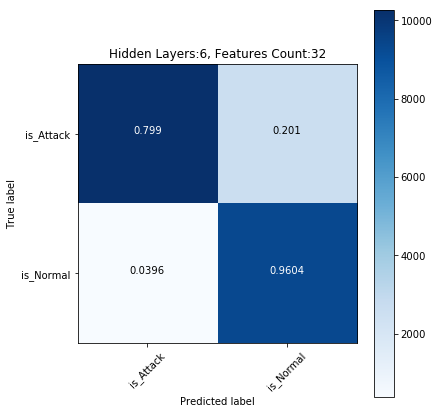

In [14]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)